# Modelos random forest para predicción de Nitrato en aguas superficiales en Chillán

In [1]:
import time
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    print(fpth)
    import flopy

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('pandas version: {}'.format(pd.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:37:49) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.20.2
matplotlib version: 3.4.2
pandas version: 1.2.4
flopy version: 3.3.3


# 1. Importar datos

## 1.1. Datos Hidroquímicos

In [2]:
from pandas import read_csv

Data=pd.read_csv('DGA_datos_FS.csv',sep=',',delimiter=',',header=None)
columnas=['Codigo1','Codigo2','Metal','Año','Fecha','Hora','algo1','algo2','algo3','igual','Estacion','unidad','algo4','Cuenca','nº Cuenca','Estado actual','tipo']
Data.columns=columnas
Data

C:\Users\EQUIPO\anaconda3\envs\env-corfo\lib\site-packages\IPython\core\interactiveshell.py:3186: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Codigo1,Codigo2,Metal,Año,Fecha,Hora,algo1,algo2,algo3,igual,Estacion,unidad,algo4,Cuenca,nº Cuenca,Estado actual,tipo
0,233679,06003003-0,Aluminio total,2000,27-01-2000,17:15,3.88,3.880,3.880,=,RIO CACHAPOAL EN BOCATOMA CHACAYES,mg/L,NaN,RIO RAPEL,60,VIGENTE,superficial
1,233680,06003003-0,Aluminio total,2000,14-04-2000,12:45,43.30,43.300,NaN,=,RIO CACHAPOAL EN BOCATOMA CHACAYES,mg/L,NaN,RIO RAPEL,60,VIGENTE,superficial
2,233681,06003003-0,Aluminio total,2000,26-07-2000,16:45,1.44,1.440,1.440,=,RIO CACHAPOAL EN BOCATOMA CHACAYES,mg/L,NaN,RIO RAPEL,60,VIGENTE,superficial
3,233682,06003003-0,Aluminio total,2000,13-10-2000,13:30,5.41,5.410,5.410,=,RIO CACHAPOAL EN BOCATOMA CHACAYES,mg/L,NaN,RIO RAPEL,60,VIGENTE,superficial
4,233683,06003003-0,Aluminio total,2001,17-01-2001,16:45,18.75,18.750,18.750,=,RIO CACHAPOAL EN BOCATOMA CHACAYES,mg/L,NaN,RIO RAPEL,60,VIGENTE,superficial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65847,385667,08141001-1,Zinc total,1997,14-10-1997,18:25,0.01,0.005,0.005,<,RIO ITATA EN COELEMU,mg/L,NaN,RIO ITATA,81,VIGENTE,superficial
65848,385668,08141001-1,Zinc total,1998,31-03-1998,15:00,0.01,0.005,0.005,<,RIO ITATA EN COELEMU,mg/L,NaN,RIO ITATA,81,VIGENTE,superficial
65849,385669,08141001-1,Zinc total,1998,30-06-1998,18:00,0.01,0.010,0.010,=,RIO ITATA EN COELEMU,mg/L,NaN,RIO ITATA,81,VIGENTE,superficial
65850,385670,08141001-1,Zinc total,1998,16-09-1998,11:40,0.01,0.005,0.005,<,RIO ITATA EN COELEMU,mg/L,NaN,RIO ITATA,81,VIGENTE,superficial


## 1.2. Datos meteorologicos

### 1.2.1. Precipitación

In [3]:
from datetime import datetime
import re
import pandas as pd

path_Pp=os.path.join('cr2_prDaily_2020','cr2_prDaily_2020.txt')

with open(path_Pp, encoding="utf8") as f:
    line=f.readlines()[3]
    nombre = line.split(',')
    
nombre=nombre[1::]
nombre=['Fecha']+nombre
nombre_df=pd.DataFrame(nombre)

Pp_all=pd.read_csv(path_Pp,delimiter=',',header=None,skiprows=15,low_memory=False)
Pp_all.columns=nombre_df[0]

def parser(x):
    return datetime.strptime(x, '%Y-%m-%d')

Pp_all['Fecha']=Pp_all['Fecha'].apply(parser)
Pp_all=Pp_all[pd.DatetimeIndex(Pp_all['Fecha']).year > 1965]

In [5]:
import re
import pandas as pd

path_Pp=os.path.join('cr2_prDaily_2020','cr2_prDaily_2020.txt')

with open(path_Pp, encoding="utf8") as f:
    line=f.readlines()[3]
    nombre = line.split(',')
    
nombre=nombre[1::]
nombre=['Fecha']+nombre
nombre_df=pd.DataFrame(nombre)
nombre_df

,0
0,Fecha
1,Visviri
2,Villa Industrial (Tacora)
3,Humapalca
4,Rio Caracarani En Humapalca
...,...
875,Chaiten Ad.
876,Futaleufu Ad.
877,Alto Palenaad.
878,Teniente Gallardo Puerto Natales Ad.


In [6]:
ini_Nuble='Millauquen'
fin_Nuble='Chillancito'

index_ini_Nuble=Pp_all.columns.get_loc(ini_Nuble)
index_fin_Nuble=Pp_all.columns.get_loc(fin_Nuble)

Pp_Nuble=pd.concat([Pp_all['Fecha'],Pp_all.iloc[:,index_ini_Nuble:index_fin_Nuble+1]],axis=1)
Pp_Nuble

,Fecha,Millauquen,San Manuel En Perquilauquen,Rio Perquilauquen En San Manuel,San Agustin De Puual,Rio Itata En Coelemu,Coelemu,Portezuelo,Dichato,San Fabian,...,Rafael,Estero Bellavista En Tom,Coihueco Embalse,Caracol,Nueva Aldea,La Punilla,Rio Sauces Antes Junta Con ÑUble,Caman,Cancha Los Litres,Chillancito
24106,1966-01-01,-9999.0,0.0,-9999.0,-9999.0,-9999.0,0.0,-9999.0,-9999.0,0.0,...,-9999.0,-9999.0,-9999.0,-9999.0,0.0,0.0,-9999.0,-9999.0,-9999.0,0.0
24107,1966-01-02,-9999.0,0.0,-9999.0,-9999.0,-9999.0,0.0,-9999.0,-9999.0,0.0,...,-9999.0,-9999.0,-9999.0,-9999.0,0.0,0.0,-9999.0,-9999.0,-9999.0,0.0
24108,1966-01-03,-9999.0,0.0,-9999.0,-9999.0,-9999.0,0.0,-9999.0,-9999.0,0.0,...,-9999.0,-9999.0,-9999.0,-9999.0,0.0,0.0,-9999.0,-9999.0,-9999.0,0.0
24109,1966-01-04,-9999.0,0.0,-9999.0,-9999.0,-9999.0,0.0,-9999.0,-9999.0,0.0,...,-9999.0,-9999.0,-9999.0,-9999.0,0.0,0.0,-9999.0,-9999.0,-9999.0,0.0
24110,1966-01-05,-9999.0,0.0,-9999.0,-9999.0,-9999.0,0.0,-9999.0,-9999.0,0.0,...,-9999.0,-9999.0,-9999.0,-9999.0,0.0,0.0,-9999.0,-9999.0,-9999.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43915,2020-03-27,-9999.0,-9999.0,0.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,0.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
43916,2020-03-28,-9999.0,-9999.0,0.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,0.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
43917,2020-03-29,-9999.0,-9999.0,0.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,0.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
43918,2020-03-30,-9999.0,-9999.0,0.1,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,0.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0


In [7]:
Pp_Nuble_2=Pp_Nuble.copy()
Pp_Nuble_2.index=pd.to_datetime(Pp_Nuble['Fecha'])
Pp_Nuble_2[pd.DatetimeIndex(Pp_Nuble_2['Fecha']).year > 1965]
Pp_Nuble_2.drop(['Fecha'],axis=1,inplace=True)
Pp_Nuble_2.replace(-9999.0, np.nan,inplace=True)
Pp_Nuble_2[['Chillan Viejo','Portezuelo','Nueva Aldea','Chillancito','Cancha Los Litres']]

,Chillan Viejo,Portezuelo,Nueva Aldea,Chillancito,Cancha Los Litres
Fecha,,,,,
1966-01-01,NaN,NaN,0.0,0.0,NaN
1966-01-02,NaN,NaN,0.0,0.0,NaN
1966-01-03,NaN,NaN,0.0,0.0,NaN
1966-01-04,NaN,NaN,0.0,0.0,NaN
1966-01-05,NaN,NaN,0.0,0.0,NaN
...,...,...,...,...,...
2020-03-27,0.0,NaN,NaN,NaN,NaN
2020-03-28,0.0,NaN,NaN,NaN,NaN
2020-03-29,0.0,NaN,NaN,NaN,NaN


***Cantidad de info por año***

In [8]:
Nuble_info_fechas=pd.DataFrame(index=Pp_Nuble_2.columns,columns=['Fecha ini','Fecha fin','Missing'])

for i in Pp_Nuble_2.columns:
    mask=Pp_Nuble_2[i].notna()
    Nuble_info_fechas['Fecha ini'].loc[i]=Pp_Nuble_2[mask].index[0].strftime('%Y/%m/%d')
    Nuble_info_fechas['Fecha fin'].loc[i]=Pp_Nuble_2[mask].index[-1].strftime('%Y/%m/%d')
    mask2=Pp_Nuble_2.loc[Pp_Nuble_2[mask].index[0]:Pp_Nuble_2[mask].index[-1]].isna()
    Nuble_info_fechas['Missing'].loc[i]=mask2[i].sum()

#### Relleno de datos de P

In [9]:
from sklearn.impute import SimpleImputer

# Add a column with the month of each record
Pp_Nuble_2['month'] = Pp_Nuble_2.index.month

# Create a dictionary to store the mean precipitation for each month
mean_precipitation_by_month = {}

# Calculate the mean precipitation for each station
for station in Pp_Nuble_2.columns:
    for month in Pp_Nuble_2['month'].unique():
        mean_precipitation = Pp_Nuble_2[(Pp_Nuble_2[station].notnull()) & (Pp_Nuble_2['month'] == month)][station].mean()
        Pp_Nuble_2.loc[(Pp_Nuble_2[station].isnull()) & (Pp_Nuble_2['month'] == month), station] = mean_precipitation
Pp_Nuble_2.drop(['month'],axis=1,inplace=True)

### 1.2.2. Temperatura

In [48]:
import re
import pandas as pd
import datetime

def parser(x):
    return datetime.datetime.strptime(x, '%Y-%m-%d')

path_T=os.path.join('cr2_tasDaily_2020','cr2_tasDaily_2020.txt')
path_Tmax=os.path.join('cr2_tasmaxDaily_2020','cr2_tasmaxDaily_2020.txt')
path_Tmin=os.path.join('cr2_tasminDaily_2020','cr2_tasminDaily_2020.txt')

with open(path_T, encoding="utf8") as f:
    line=f.readlines()[3]
    nombre = line.split(',')    
nombre=nombre[1::]
nombre=['Fecha']+nombre
nombre_df=pd.DataFrame(nombre)
T_all=pd.read_csv(path_T,delimiter=',',header=None,skiprows=15,low_memory=False)
T_all.columns=nombre_df[0]
T_all['Fecha']=T_all['Fecha'].apply(parser)

with open(path_Tmax, encoding="utf8") as f:
    line=f.readlines()[3]
    nombre_max = line.split(',')
nombre_max=nombre_max[1::]
nombre_max=['Fecha']+nombre_max
nombre_max_df=pd.DataFrame(nombre_max)
T_max=pd.read_csv(path_Tmax,delimiter=',',header=None,skiprows=15,low_memory=False)
T_max.columns=nombre_max_df[0]
T_max['Fecha']=T_max['Fecha'].apply(parser)

with open(path_Tmin, encoding="utf8") as f:
    line=f.readlines()[3]
    nombre_min = line.split(',')
    
nombre_min=nombre_min[1::]
nombre_min=['Fecha']+nombre_min
nombre_min_df=pd.DataFrame(nombre_min)
T_min=pd.read_csv(path_Tmin,delimiter=',',header=None,skiprows=15,low_memory=False)
T_min.columns=nombre_min_df[0]
T_min['Fecha']=T_min['Fecha'].apply(parser)

***Temp. maximas y minimas***

Estacion Nueva Aldea (INIA)

In [335]:
import datetime
path_Tmean_NuevaAldea = os.path.join('Datos Tmean Nueva Aldea_06-2009 a 12-2020.csv')
T_mean_NuevaAldea = pd.read_csv(path_Tmean_NuevaAldea,delimiter=',',header=None,skiprows=6,skipfooter=4,engine='python')#,low_memory=False)
T_mean_NuevaAldea.columns = ['Fecha','T mean','% datos']
T_mean_NuevaAldea['Date'] = pd.to_datetime(T_mean_NuevaAldea['Fecha'])
T_mean_NuevaAldea.drop(['% datos'],axis=1,inplace=True)
T_mean_NuevaAldea.index = T_mean_NuevaAldea['Date'] 
T_mean_NuevaAldea.drop(['Date'],axis=1,inplace=True)

#start = datetime.datetime.strptime('2010-04-01', '%Y-%m-%d')
#end = datetime.datetime.strptime('2019-01-01', '%Y-%m-%d')
#T_mean_NuevaAldea = T_mean_NuevaAldea.loc[(T_mean_NuevaAldea.index > start) & (T_mean_NuevaAldea.index < end),:]

path_Tmin_NuevaAldea = os.path.join('Datos Tmin Nueva Aldea_06-2009 a 12-2020.csv')
T_min_NuevaAldea = pd.read_csv(path_Tmin_NuevaAldea,delimiter=',',header=None,skiprows=6,skipfooter=4,engine='python')#,low_memory=False)
T_min_NuevaAldea.columns = ['Fecha','T min','% datos']
T_min_NuevaAldea['Date'] = pd.to_datetime(T_min_NuevaAldea['Fecha'])
T_min_NuevaAldea.drop(['% datos'],axis=1,inplace=True)
T_min_NuevaAldea.index = T_min_NuevaAldea['Date'] 
T_min_NuevaAldea.drop(['Date'],axis=1,inplace=True)
#T_min_NuevaAldea = T_min_NuevaAldea.loc[(T_min_NuevaAldea.index > start) & (T_min_NuevaAldea.index < end),:]
T_min_NuevaAldea

path_Tmax_NuevaAldea = os.path.join('Datos Tmax Nueva Aldea_06-2009 a 12-2020.csv')
T_max_NuevaAldea = pd.read_csv(path_Tmax_NuevaAldea,delimiter=',',header=None,skiprows=6,skipfooter=4,engine='python')#,low_memory=False)
T_max_NuevaAldea.columns = ['Fecha','T max','% datos']
T_max_NuevaAldea['Date'] = pd.to_datetime(T_max_NuevaAldea['Fecha'])
T_max_NuevaAldea.drop(['% datos'],axis=1,inplace=True)
T_max_NuevaAldea.index = T_max_NuevaAldea['Date'] 
T_max_NuevaAldea.drop(['Date'],axis=1,inplace=True)
#T_max_NuevaAldea = T_max_NuevaAldea.loc[(T_max_NuevaAldea.index > start) & (T_max_NuevaAldea.index < end),:]
T_max_NuevaAldea

,Fecha,T max
Date,,
2009-01-06,01-06-2009,NaN
2009-02-06,02-06-2009,NaN
2009-03-06,03-06-2009,NaN
2009-04-06,04-06-2009,NaN
2009-05-06,05-06-2009,NaN
...,...,...
2023-02-02,02-02-2023,33.1
2023-03-02,03-02-2023,41.3
2023-04-02,04-02-2023,23.6


Estacion Portezuelo 

In [81]:
import datetime
path_Tmean_Portezuelo = os.path.join('Datos Tmean Portezuelo_06-2009 a 12-2020.csv')
T_mean_Portezuelo = pd.read_csv(path_Tmean_Portezuelo,delimiter=',',header=None,skiprows=6,skipfooter=4,engine='python')#,low_memory=False)
T_mean_Portezuelo.columns = ['Fecha','T mean','% datos']
T_mean_Portezuelo['Date'] = pd.to_datetime(T_mean_Portezuelo['Fecha'])
T_mean_Portezuelo.drop(['% datos'],axis=1,inplace=True)
T_mean_Portezuelo.index = T_mean_Portezuelo['Date'] 
T_mean_Portezuelo.drop(['Date'],axis=1,inplace=True)
start = datetime.datetime.strptime('2010-04-01', '%Y-%m-%d')
end = datetime.datetime.strptime('2019-01-01', '%Y-%m-%d')
#T_mean_Portezuelo = T_mean_Portezuelo.loc[(T_mean_Portezuelo.index > start) & (T_mean_Portezuelo.index < end),:]

path_Tmin_Portezuelo = os.path.join('Datos Tmin Portezuelo_06-2009 a 12-2020.csv')
T_min_Portezuelo = pd.read_csv(path_Tmin_Portezuelo,delimiter=',',header=None,skiprows=6,skipfooter=4,engine='python')#,low_memory=False)
T_min_Portezuelo.columns = ['Fecha','T min','% datos']
T_min_Portezuelo['Date'] = pd.to_datetime(T_min_Portezuelo['Fecha'])
T_min_Portezuelo.drop(['% datos'],axis=1,inplace=True)
T_min_Portezuelo.index = T_min_Portezuelo['Date'] 
T_min_Portezuelo.drop(['Date'],axis=1,inplace=True)
#T_min_Portezuelo = T_min_Portezuelo.loc[(T_min_Portezuelo.index > start) & (T_min_Portezuelo.index < end),:]

path_Tmax_Portezuelo = os.path.join('Datos Tmax Portezuelo_06-2009 a 12-2020.csv')
T_max_Portezuelo = pd.read_csv(path_Tmax_Portezuelo,delimiter=',',header=None,skiprows=6,skipfooter=4,engine='python')#,low_memory=False)
T_max_Portezuelo.columns = ['Fecha','T max','% datos']
T_max_Portezuelo['Date'] = pd.to_datetime(T_max_Portezuelo['Fecha'])
T_max_Portezuelo.drop(['% datos'],axis=1,inplace=True)
T_max_Portezuelo.index = T_max_Portezuelo['Date'] 
T_max_Portezuelo.drop(['Date'],axis=1,inplace=True)
#T_max_Portezuelo = T_max_Portezuelo.loc[(T_max_Portezuelo.index > start) & (T_max_Portezuelo.index < end),:]
T_max_Portezuelo

,Fecha,T max
Date,,
2009-01-06,01-06-2009,NaN
2009-02-06,02-06-2009,NaN
2009-03-06,03-06-2009,NaN
2009-04-06,04-06-2009,NaN
2009-05-06,05-06-2009,NaN
...,...,...
2023-02-02,02-02-2023,34.4
2023-03-02,03-02-2023,40.5
2023-04-02,04-02-2023,24.7


Estación Bernardo O'Higgins

In [82]:
"Bernardo O'Higgins Chillan Ad."
import re
import pandas as pd

path_Tmax=os.path.join('cr2_tasmaxDaily_2020','cr2_tasmaxDaily_2020.txt')

with open(path_Tmax, encoding="utf8") as f:
    line=f.readlines()[3]
    nombre_max = line.split(',')

path_Tmin=os.path.join('cr2_tasminDaily_2020','cr2_tasminDaily_2020.txt')

with open(path_Tmin, encoding="utf8") as f:
    line=f.readlines()[3]
    nombre_min = line.split(',')

pos_BoHiggins=T_all.columns.get_loc("Bernardo O'Higgins Chillan Ad.")
T_BoHiggins=pd.concat([T_all['Fecha'],T_all.iloc[:,pos_BoHiggins]],axis=1)

pos_BoHiggins_max=T_max.columns.get_loc("Bernardo O'Higgins Chillan Ad.")
pos_BoHiggins_min=T_min.columns.get_loc("Bernardo O'Higgins Chillan Ad.")
Tmax_BoHiggins=pd.concat([T_max['Fecha'],T_max.iloc[:,pos_BoHiggins_max]],axis=1)
Tmin_BoHiggins=pd.concat([T_min['Fecha'],T_min.iloc[:,pos_BoHiggins_min]],axis=1)

T_BoHiggins_2=T_BoHiggins.copy()
T_BoHiggins_2.index=pd.to_datetime(T_BoHiggins['Fecha'])
start = datetime.datetime.strptime('2010-04-01', '%Y-%m-%d')
end = datetime.datetime.strptime('2019-01-01', '%Y-%m-%d')
#T_BoHiggins_2 = T_BoHiggins_2.loc[(T_BoHiggins_2.index > start) & (T_BoHiggins_2.index < end),:]

T_BoHiggins_2.drop(['Fecha'],axis=1,inplace=True)
T_BoHiggins_2.replace(-9999.0, np.nan,inplace=True)

Tmax_BoHiggins_2=Tmax_BoHiggins.copy()
Tmax_BoHiggins_2.index=pd.to_datetime(Tmax_BoHiggins['Fecha'])
Tmax_BoHiggins_2.drop(['Fecha'],axis=1,inplace=True)
Tmax_BoHiggins_2.replace(-9999.0, np.nan,inplace=True)
#Tmax_BoHiggins_2 = Tmax_BoHiggins_2.loc[(Tmax_BoHiggins_2.index > start) & (Tmax_BoHiggins_2.index < end),:]

Tmin_BoHiggins_2=Tmin_BoHiggins.copy()
Tmin_BoHiggins_2.index=pd.to_datetime(Tmin_BoHiggins['Fecha'])
Tmin_BoHiggins_2.drop(['Fecha'],axis=1,inplace=True)
Tmin_BoHiggins_2.replace(-9999.0, np.nan,inplace=True)
#Tmin_BoHiggins_2 = Tmin_BoHiggins_2.loc[(Tmin_BoHiggins_2.index > start) & (Tmin_BoHiggins_2.index < end),:]

In [83]:
Tmean_Nuble=pd.concat([T_BoHiggins_2, T_mean_Portezuelo['T mean'],T_mean_NuevaAldea['T mean']],axis=1)
Tmean_Nuble.columns = ["Bernardo O'Higgins Chillan Ad. Tmean", 'Portezuelo Tmean','Nueva Aldea Tmean']
Tmax_Nuble=pd.concat([Tmax_BoHiggins_2, T_max_Portezuelo['T max'],T_max_NuevaAldea['T max']],axis=1)
Tmax_Nuble.columns = ["Bernardo O'Higgins Chillan Ad. Tmax", 'Portezuelo Tmax','Nueva Aldea Tmax']
Tmin_Nuble=pd.concat([Tmin_BoHiggins_2, T_min_Portezuelo['T min'],T_min_NuevaAldea['T min']],axis=1)
Tmin_Nuble.columns = ["Bernardo O'Higgins Chillan Ad. Tmin", 'Portezuelo Tmin','Nueva Aldea Tmin']
Tmean_Nuble

,Bernardo O'Higgins Chillan Ad. Tmean,Portezuelo Tmean,Nueva Aldea Tmean
1900-01-01,NaN,NaN,NaN
1900-01-02,NaN,NaN,NaN
1900-01-03,NaN,NaN,NaN
1900-01-04,NaN,NaN,NaN
1900-01-05,NaN,NaN,NaN
...,...,...,...
2023-08-01,NaN,NaN,21.6
2023-09-01,NaN,NaN,20.9
2023-10-01,NaN,NaN,23.4
2023-11-01,NaN,NaN,19.1


#### Relleno de datos de T

In [84]:
from sklearn.impute import SimpleImputer

# Add a column with the month of each record
Tmean_Nuble['month'] = Tmean_Nuble.index.month
Tmax_Nuble['month'] = Tmax_Nuble.index.month
Tmin_Nuble['month'] = Tmin_Nuble.index.month

# Create a dictionary to store the mean precipitation for each month
mean_temp_by_month = {}

# Calculate the mean precipitation for each station
for station in Tmax_Nuble.columns:
    print(station)
    if 'month' not in station:
        station_name = station.split(' T')[0]
        for month in Tmax_Nuble['month'].unique():
            mean_temp = Tmean_Nuble[(Tmean_Nuble[station_name+' Tmean'].notnull()) & (Tmean_Nuble['month'] == month)][station_name+' Tmean'].mean()
            Tmean_Nuble.loc[(Tmean_Nuble[station_name+' Tmean'].isnull()) & (Tmean_Nuble['month'] == month), station_name+' Tmean'] = mean_temp

            mean_temp = Tmax_Nuble[(Tmax_Nuble[station_name+' Tmax'].notnull()) & (Tmax_Nuble['month'] == month)][station_name+' Tmax'].mean()
            Tmax_Nuble.loc[(Tmax_Nuble[station_name+' Tmax'].isnull()) & (Tmax_Nuble['month'] == month), station_name+' Tmax'] = mean_temp

            mean_temp_Tmin = Tmin_Nuble[(Tmin_Nuble[station_name+' Tmin'].notnull()) & (Tmin_Nuble['month'] == month)][station_name+' Tmin'].mean()
            Tmin_Nuble.loc[(Tmin_Nuble[station_name+' Tmin'].isnull()) & (Tmin_Nuble['month'] == month), station_name+' Tmin'] = mean_temp_Tmin
Tmean_Nuble.drop(['month'],axis=1,inplace=True)
Tmax_Nuble.drop(['month'],axis=1,inplace=True)
Tmin_Nuble.drop(['month'],axis=1,inplace=True)

Bernardo O'Higgins Chillan Ad. Tmax
Portezuelo Tmax
Nueva Aldea Tmax
month


Tmin_Nuble_relleno

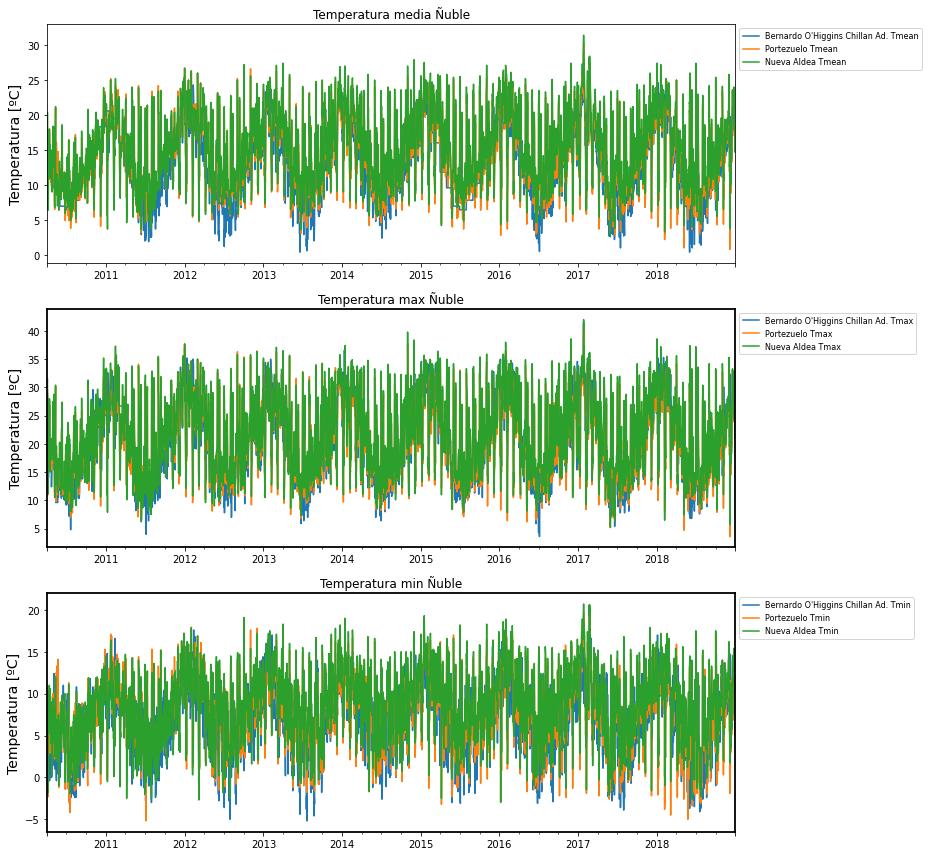

In [17]:
plt.figure(figsize=(13, 12))
ax1 = plt.subplot(3,1,1)
w=0
Tmean_Nuble.plot(ax=ax1)
ax1.set_title('Temperatura media Ñuble')
plt.tight_layout()
ax1.legend(bbox_to_anchor=(1+w,1), loc="upper left",fontsize=8)#,labels=['EEFlux','Pre-calib','Sim1','Sim2','Sim3','Sim4'])
ax1.set_ylabel('Temperatura [ºC]',fontsize=14)
ax1.xaxis.label.set_size(0)
mpl.rcParams['axes.linewidth'] = 1.8 #set the value globally
plt.tight_layout(pad=2,w_pad=0.3)

ax2 = plt.subplot(3,1,2)
Tmax_Nuble.plot(ax=ax2)
ax2.set_title('Temperatura max Ñuble')
plt.tight_layout()
ax2.legend(bbox_to_anchor=(1+w,1), loc="upper left",fontsize=8)#,labels=['EEFlux','Pre-calib','Sim1','Sim2','Sim3','Sim4'])
ax2.set_ylabel('Temperatura [ºC]',fontsize=14)
plt.subplots_adjust(right=0.7)
ax2.xaxis.label.set_size(0)

ax3 = plt.subplot(3,1,3)
Tmin_Nuble.plot(ax=ax3)
ax3.set_title('Temperatura min Ñuble')
ax3.legend(bbox_to_anchor=(1+w,1), loc="upper left",fontsize=8)#,labels=['EEFlux','Pre-calib','Sim1','Sim2','Sim3','Sim4'])
ax3.set_ylabel('Temperatura [ºC]',fontsize=14)
plt.subplots_adjust(right=0.7)
ax3.xaxis.label.set_size(0)
plt.tight_layout(w_pad=0.3)

#plt.savefig('Temperaturas diarias Ñuble.png', dpi=300)

# 2. Machine learning

## 2.1. Random Forest

Random Forest can also be used for time series forecasting, although it requires that the time series dataset be transformed into a supervised learning problem first. It also requires the use of a specialized technique for evaluating the model called walk-forward validation, as evaluating the model using k-fold cross validation would result in optimistically biased results.

The model must be trained on the past and predict the future.

This means that methods that randomize the dataset during evaluation, like k-fold cross-validation, cannot be used. Instead, we must use a technique called walk-forward validation.In walk-forward validation, the dataset is first split into train and test sets by selecting a cut point, e.g. all data except the last 12 months is used for training and the last 12 months is used for testing.

If we are interested in making a one-step forecast, e.g. one month, then we can evaluate the model by training on the training dataset and predicting the first step in the test dataset. We can then add the real observation from the test set to the training dataset, refit the model, then have the model predict the second step in the test dataset.

***https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/***

### (*) Definir Sliding window para predecir series temporales

***https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/***

In [18]:
def series_to_supervised2(data, n_in=1, n_out=1, dropnan=True, keep_cols = False):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    if keep_cols == True:
        columns = [j for j in data.columns]
        print(columns)
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        if keep_cols == False:
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        else:
            names += [j+'(t-%d)' % (i) for j in columns]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            if keep_cols == False:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                print(j+'(t)' for j in columns)
                names += [j+'(t)' for j in columns]
        else:
            if keep_cols == False:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            else:
                names += [j+'(t+%d)' % (i) for j in columns]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
 
raw = pd.DataFrame()
raw['ob1'] = [x for x in range(10)]
raw['ob2'] = [x for x in range(50, 60)]
values = raw.values


### (**) Time series split

In [20]:
from sklearn.model_selection._split import TimeSeriesSplit
from sklearn.utils.validation import _deprecate_positional_args
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples

class WindowedTestTimeSeriesSplit(TimeSeriesSplit):
    """
    parameters
    ----------
    n_test_folds: int
        number of folds to be used as testing at each iteration.
        by default, 1.
    """
    @_deprecate_positional_args
    def __init__(self, n_splits=5, *, max_train_size=None, n_test_folds=1):
        super().__init__(n_splits, 
                         max_train_size=max_train_size)
        self.n_test_folds=n_test_folds

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + self.n_test_folds
        if n_folds > n_samples:
            raise ValueError(
                ("Cannot have number of folds ={0} greater"
                 " than the number of samples: {1}.").format(n_folds,
                                                             n_samples))
        indices = np.arange(n_samples)
        fold_size = (n_samples // n_folds)
        test_size = fold_size * self.n_test_folds # test window
        test_starts = range(fold_size + n_samples % n_folds,
                            n_samples-test_size+1, fold_size) # splits based on fold_size instead of test_size
        for test_start in test_starts:
            if self.max_train_size and self.max_train_size < test_start:
                yield (indices[test_start - self.max_train_size:test_start],
                       indices[test_start:test_start + test_size])
            else:
                yield (indices[:test_start],
                       indices[test_start:test_start + test_size])

In [462]:
#Ejemplo de como usar WindowedTestTimeSeriesSplit 
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])
tscv = WindowedTestTimeSeriesSplit(max_train_size=3,n_splits=4, n_test_folds=2)
print(tscv)

for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(X_train)
    print(y_train)

WindowedTestTimeSeriesSplit(max_train_size=3, n_splits=4, n_test_folds=2)
TRAIN: [0] TEST: [1 2]
[[1 2]]
[1]
TRAIN: [0 1] TEST: [2 3]
[[1 2]
 [3 4]]
[1 2]
TRAIN: [0 1 2] TEST: [3 4]
[[1 2]
 [3 4]
 [1 2]]
[1 2 3]
TRAIN: [1 2 3] TEST: [4 5]
[[3 4]
 [1 2]
 [3 4]]
[2 3 4]


### (***) Walk-forward validation for univariate data

In practice, we very likely will retrain our model as new data becomes available. This would give the model the best opportunity to make good forecasts at each time step. We can evaluate our machine learning models under this assumption. There are few decisions to make:

1. Minimum Number of Observations. First, we must select the minimum number of observations required to train the model. This may be thought of as the window width if a sliding window is used (see next point).
2. Sliding or Expanding Window. Next, we need to decide whether the model will be trained on all data it has available or only on the most recent observations. This determines whether a sliding or expanding window will be used.

After a sensible configuration is chosen for your test-setup, models can be trained and evaluated. Starting at the beginning of the time series, the minimum number of samples in the window is used to train a model. The model makes a prediction for the next time step. The prediction is stored or evaluated against the known value. The window is expanded to include the known value and the process is repeated (go to step 1.)

In [19]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = random_forest_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, 1], predictions

## _A) Estación hidroquímica: 'RIO CHILLAN EN LONGITUDINAL'_

### **(1) Datasets para entrenar y validar**

In [115]:
grupos_x2=Data.groupby(['Estacion'],sort=False).get_group('RIO CHILLAN EN LONGITUDINAL')

grupos_x2=grupos_x2[grupos_x2['tipo'] =='superficial']

In [116]:
grupo_i=pd.DataFrame(grupos_x2.loc[:,['Metal','Fecha','algo2']])
grupo_i['Date'] = pd.to_datetime(grupo_i['Fecha'])
X=grupo_i.pivot(index="Date", columns='Metal',values="algo2")
X.rename_axis(None, axis=1, inplace = True)
X

,Aluminio total,Ars�nico total,Bicarbonato,Boro total,Cadmio total,Calcio total,Cloruro total,Cobalto total,Cobre total,Conductividad espec�fica 25�C,...,Plata total,Plomo total,Potasio total,RAS,Selenio total,Sodio total,Sulfato,Temperatura del agua,Zinc total,pH
Date,,,,,,,,,,,,,,,,,,,,,
1966-06-12,NaN,NaN,47.595,1.00,NaN,6.212,18.434,NaN,NaN,94.0,...,NaN,NaN,1.564,NaN,NaN,5.977,13.449,NaN,NaN,7.400
1966-08-08,NaN,NaN,50.646,NaN,NaN,8.216,12.408,NaN,NaN,85.0,...,NaN,NaN,1.173,NaN,NaN,7.816,2.882,NaN,NaN,7.100
1966-08-09,NaN,NaN,50.646,NaN,NaN,7.014,8.863,NaN,NaN,NaN,...,NaN,NaN,0.782,NaN,NaN,5.517,21.614,NaN,NaN,7.200
1966-11-14,NaN,NaN,15.255,NaN,NaN,3.607,9.572,NaN,NaN,91.0,...,NaN,NaN,1.173,NaN,NaN,7.127,14.410,NaN,NaN,7.270
1969-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-06,NaN,0.002,NaN,0.19,0.005,8.814,6.724,NaN,0.005,165.0,...,0.005,0.01,NaN,NaN,0.0005,NaN,18.738,9.830,0.005,7.860
2017-09-21,NaN,0.001,NaN,NaN,NaN,6.382,4.550,NaN,0.005,103.0,...,NaN,NaN,NaN,NaN,NaN,NaN,6.469,11.630,0.005,7.920
2017-12-14,NaN,0.002,NaN,NaN,0.005,8.779,NaN,NaN,0.005,201.0,...,0.005,0.01,1.871,NaN,0.0005,20.505,NaN,19.730,0.005,7.629


### (2) Elegir predictores hidrogeoqmcos con mayor correlación

In [117]:
X_corr=X.corr()['Nitrogeno de nitrato'].sort_values()
nan_loc=np.where(np.isnan(X_corr))
X_corr=X_corr.drop(X_corr[nan_loc[0]].index, axis=0)

loc_good_corr = X_corr[X_corr >=0.7].index
#X_corr[X_corr >=0.7] or X_corr <=-0.7]
loc_good_corr = loc_good_corr.append(X_corr[X_corr <=-0.7].index)
X_2 = X[loc_good_corr]
X_2 

,Potasio total,Conductividad espec�fica 25�C,Cloruro total,Fosforo de ortofosfato,Nitrogeno de nitrato
Date,,,,,
1966-06-12,1.564,94.0,18.434,NaN,NaN
1966-08-08,1.173,85.0,12.408,NaN,NaN
1966-08-09,0.782,NaN,8.863,NaN,NaN
1966-11-14,1.173,91.0,9.572,NaN,NaN
1969-01-14,NaN,200.0,NaN,NaN,NaN
...,...,...,...,...,...
2017-08-06,NaN,165.0,6.724,NaN,NaN
2017-09-21,NaN,103.0,4.550,NaN,NaN
2017-12-14,1.871,201.0,NaN,NaN,NaN


### (3) Agregar P y Tº de estaciones cercanas a la matriz de predictores por fecha

#### a) Dejo solo las filas donde existen valores reales del predictor

In [122]:
loc_notnan = np.where(np.isnan(X_2['Nitrogeno de nitrato'])==False)[0]
X_2_filter = X_2.iloc[loc_notnan,:]
X_2

,Potasio total,Conductividad espec�fica 25�C,Cloruro total,Fosforo de ortofosfato,Nitrogeno de nitrato
Date,,,,,
1966-06-12,1.564,94.0,18.434,NaN,NaN
1966-08-08,1.173,85.0,12.408,NaN,NaN
1966-08-09,0.782,NaN,8.863,NaN,NaN
1966-11-14,1.173,91.0,9.572,NaN,NaN
1969-01-14,NaN,200.0,NaN,NaN,NaN
...,...,...,...,...,...
2017-08-06,NaN,165.0,6.724,NaN,NaN
2017-09-21,NaN,103.0,4.550,NaN,NaN
2017-12-14,1.871,201.0,NaN,NaN,NaN


#### b) Creo nuevos dataframes de T y P con los registros más cercanos a las fechas donde hay valores reales del predictor

In [119]:
loc_datesTmean = [Tmean_Nuble.index.get_loc(pd.to_datetime(i), method = 'nearest') for i in X_2_filter.index]
Tmean_Nuble_filter = Tmean_Nuble.iloc[loc_datesTmean]

loc_datesTmax = [Tmax_Nuble.index.get_loc(pd.to_datetime(i), method = 'nearest') for i in X_2_filter.index]
Tmax_Nuble_filter = Tmax_Nuble.iloc[loc_datesTmax]

loc_datesTmin = [Tmin_Nuble.index.get_loc(pd.to_datetime(i), method = 'nearest') for i in X_2_filter.index]
Tmin_Nuble_filter = Tmin_Nuble.iloc[loc_datesTmin]
#Tmean_Nuble.index.get_loc(pd.DataFrame(X_2.iloc[loc_notnan,:].index)['Date'].values)

In [120]:
P_Chillan = Pp_Nuble_2[['Chillan Viejo','Portezuelo','Nueva Aldea']]#,'Canal De La Luz En Chillan']]
loc_datesP = [P_Chillan.index.get_loc(pd.to_datetime(i), method = 'nearest') for i in X_2_filter.index]
P_Chillan_filter = P_Chillan.iloc[loc_datesP]
P_Chillan_filter

,Chillan Viejo,Portezuelo,Nueva Aldea
Fecha,,,
1997-08-09,0.0,3.809544,0.0
1997-12-12,0.0,0.544758,0.0
1998-01-12,0.0,0.209677,0.0
1998-09-23,0.0,2.105485,0.0
1998-10-06,0.0,1.304608,0.0
1998-11-03,0.0,0.790476,0.0
2000-03-30,0.0,0.633065,0.0
2000-06-22,30.0,4.712500,17.5
2000-09-27,0.0,2.105485,0.0


In [125]:
X_3 = pd.concat([X_2_filter, Tmean_Nuble_filter,Tmax_Nuble_filter,Tmin_Nuble_filter, P_Chillan_filter],axis = 1)
X_3

,Potasio total,Conductividad espec�fica 25�C,Cloruro total,Fosforo de ortofosfato,Nitrogeno de nitrato,Bernardo O'Higgins Chillan Ad. Tmean,Portezuelo Tmean,Nueva Aldea Tmean,Bernardo O'Higgins Chillan Ad. Tmax,Portezuelo Tmax,Nueva Aldea Tmax,Bernardo O'Higgins Chillan Ad. Tmin,Portezuelo Tmin,Nueva Aldea Tmin,Chillan Viejo,Portezuelo,Nueva Aldea
1997-08-09,NaN,59.0,NaN,NaN,0.800,12.600000,11.896429,12.415212,22.8,17.696800,18.384058,6.6,6.092857,6.579052,0.0,3.809544,0.0
1997-12-12,NaN,68.1,NaN,0.979000,0.670,17.700000,17.719485,18.423940,21.8,25.431139,25.782971,15.2,10.366544,10.923691,0.0,0.544758,0.0
1998-01-12,6.160,316.0,31.900,2.652000,7.788,20.000000,19.292149,19.667413,31.8,27.043766,27.536290,10.0,11.685950,11.894527,0.0,0.209677,0.0
1998-09-23,NaN,125.7,NaN,0.695000,1.580,9.942282,12.944490,13.877577,17.4,19.465385,20.255056,4.6,6.740816,7.441237,0.0,2.105485,0.0
1998-10-06,NaN,41.6,NaN,0.369000,0.810,12.080470,14.362451,15.160100,17.4,21.237500,21.926449,5.6,7.841502,8.358603,0.0,1.304608,0.0
1998-11-03,NaN,175.5,NaN,2.772000,4.910,15.167539,16.207985,17.028351,23.0,23.678272,24.187640,8.4,9.152091,9.732990,0.0,0.790476,0.0
2000-03-30,6.700,295.0,34.300,3.755000,7.957,14.600000,16.926639,17.460836,21.6,24.118037,25.151613,10.6,9.656967,10.103133,0.0,0.633065,0.0
2000-06-22,NaN,12.8,NaN,0.022000,0.749,13.000000,11.025600,11.595876,15.0,16.409065,16.945113,12.4,5.940800,6.463918,30.0,4.712500,17.5
2000-09-27,NaN,67.6,NaN,0.082000,0.746,13.200000,12.944490,13.877577,23.0,19.465385,20.255056,6.8,6.740816,7.441237,0.0,2.105485,0.0
2000-12-19,NaN,171.7,NaN,0.642000,0.010,19.900000,17.719485,18.423940,30.0,25.431139,25.782971,11.6,10.366544,10.923691,0.0,0.544758,0.0


### (4) Relleno datos faltantes con SimpleImputer

In [126]:
from sklearn.impute import SimpleImputer

# Add a column with the month of each record
X_3['month'] = X_3.index.month

# Create a dictionary to store the mean precipitation for each month
mean_precipitation_by_month = {}

# Calculate the mean precipitation for each metal
for metal in X_3.columns:
    print(metal)
    for month in X_3['month'].unique():
        if np.unique(X_3[metal].notnull())[0] == False:
            mean_concentration = X_3[metal][(X_3[metal].notnull()) & (X_3['month'] == month)].mean()
            X_3.loc[(X_3[metal].isnull()) & (X_3['month'] == month), metal] = mean_concentration

X_3.drop(['month'],axis=1,inplace=True)

Potasio total
Conductividad espec�fica 25�C
Cloruro total
Fosforo de ortofosfato
Nitrogeno de nitrato
Bernardo O'Higgins Chillan Ad. Tmean
Portezuelo Tmean
Nueva Aldea Tmean
Bernardo O'Higgins Chillan Ad. Tmax
Portezuelo Tmax
Nueva Aldea Tmax
Bernardo O'Higgins Chillan Ad. Tmin
Portezuelo Tmin
Nueva Aldea Tmin
Chillan Viejo
Portezuelo
Nueva Aldea
month


### (5) ***Formato de la matriz de predictores+y con desfase temporal***

In [127]:
X_lag = series_to_supervised2(X_3, n_in=2, n_out=1, dropnan=True,keep_cols = True)
print(X_lag)

['Potasio total', 'Conductividad espec�fica 25�C', 'Cloruro total', 'Fosforo de ortofosfato', 'Nitrogeno de nitrato', "Bernardo O'Higgins Chillan Ad. Tmean", 'Portezuelo Tmean', 'Nueva Aldea Tmean', "Bernardo O'Higgins Chillan Ad. Tmax", 'Portezuelo Tmax', 'Nueva Aldea Tmax', "Bernardo O'Higgins Chillan Ad. Tmin", 'Portezuelo Tmin', 'Nueva Aldea Tmin', 'Chillan Viejo', 'Portezuelo', 'Nueva Aldea']
<generator object series_to_supervised2.<locals>.<genexpr> at 0x00000156433437C8>
            Potasio total(t-2)  Conductividad espec�fica 25�C(t-2)  \
1998-01-12            1.399667                                59.0   
1998-09-23            4.856600                                68.1   
1998-10-06            6.160000                               316.0   
1998-11-03            1.500000                               125.7   
2000-03-30            6.292500                                41.6   
2001-03-16            1.500000                                67.6   
2002-04-12            4.856

In [174]:
X_lag.loc[:,X_lag.drop(['Nitrogeno de nitrato(t)'],axis=1,inplace=False).columns]

,Potasio total(t-2),Conductividad espec�fica 25�C(t-2),Cloruro total(t-2),Fosforo de ortofosfato(t-2),Nitrogeno de nitrato(t-2),Bernardo O'Higgins Chillan Ad. Tmean(t-2),Portezuelo Tmean(t-2),Nueva Aldea Tmean(t-2),Bernardo O'Higgins Chillan Ad. Tmax(t-2),Portezuelo Tmax(t-2),...,Nueva Aldea Tmean(t),Bernardo O'Higgins Chillan Ad. Tmax(t),Portezuelo Tmax(t),Nueva Aldea Tmax(t),Bernardo O'Higgins Chillan Ad. Tmin(t),Portezuelo Tmin(t),Nueva Aldea Tmin(t),Chillan Viejo(t),Portezuelo(t),Nueva Aldea(t)
1998-01-12,1.399667,59.0,5.206333,0.102667,0.800,12.600000,11.896429,12.415212,22.8,17.696800,...,19.667413,31.8,27.043766,27.536290,10.0,11.685950,11.894527,0.0,0.209677,0.0
1998-09-23,4.856600,68.1,17.711800,0.979000,0.670,17.700000,17.719485,18.423940,21.8,25.431139,...,13.877577,17.4,19.465385,20.255056,4.6,6.740816,7.441237,0.0,2.105485,0.0
1998-10-06,6.160000,316.0,31.900000,2.652000,7.788,20.000000,19.292149,19.667413,31.8,27.043766,...,15.160100,17.4,21.237500,21.926449,5.6,7.841502,8.358603,0.0,1.304608,0.0
1998-11-03,1.500000,125.7,2.855000,0.695000,1.580,9.942282,12.944490,13.877577,17.4,19.465385,...,17.028351,23.0,23.678272,24.187640,8.4,9.152091,9.732990,0.0,0.790476,0.0
2000-03-30,6.292500,41.6,31.669000,0.369000,0.810,12.080470,14.362451,15.160100,17.4,21.237500,...,17.460836,21.6,24.118037,25.151613,10.6,9.656967,10.103133,0.0,0.633065,0.0
2001-03-16,1.500000,67.6,2.855000,0.082000,0.746,13.200000,12.944490,13.877577,23.0,19.465385,...,17.460836,30.0,24.118037,25.151613,11.2,9.656967,10.103133,0.0,0.633065,0.0
2002-04-12,4.856600,277.0,17.711800,1.386000,1.954,24.000000,17.719485,18.423940,33.6,25.431139,...,14.926735,18.8,20.829504,21.560300,9.5,7.756870,8.265553,1.0,1.084937,8.5
2003-12-16,4.300000,207.0,19.049000,1.337000,2.009,16.000000,17.719485,18.423940,21.5,25.431139,...,18.423940,26.8,25.431139,25.782971,7.0,10.366544,10.923691,0.0,0.544758,0.0
2005-10-08,1.440000,47.0,2.948000,0.168000,0.935,15.500000,17.719485,18.423940,23.2,25.431139,...,15.160100,24.6,21.237500,21.926449,6.4,7.841502,8.358603,0.0,1.304608,0.0
2005-11-03,4.856600,145.0,17.711800,0.473000,0.208,15.500000,17.719485,18.423940,24.6,25.431139,...,17.028351,18.6,23.678272,24.187640,12.6,9.152091,9.732990,0.5,0.790476,0.0


###  (6) Modelos Random Forest: Nitrato como contaminante a predecir

#### a) Predictores: Todas las variables

In [219]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_forw=np.array(X_lag.drop(['Nitrogeno de nitrato(t)'],axis=1,inplace=False))
y_forw = np.array(X_lag['Nitrogeno de nitrato(t)'])

max_train_size=8
n_splits=4#int(np.round(len(X_forw)*0.6)/5)
tscv = WindowedTestTimeSeriesSplit(max_train_size = max_train_size, n_splits=n_splits, n_test_folds=1)

rf_1 = {}
training_dates = {}
count = 0
index_scores = [ "window_{0}".format(n) for n in np.arange(0,n_splits)]
scores_df = pd.DataFrame(index = index_scores,columns = ['MSE','RMSE','R2'])
for train_index, test_index in tscv.split(X_forw):
    count+=1
    X_train, X_test = X_forw[train_index], X_forw[test_index]
    y_train, y_test = y_forw[train_index], y_forw[test_index]
    rf = RandomForestRegressor(n_estimators = 100,max_features = 'sqrt',
                                random_state=0).fit(X_train, y_train)
    #rf_1["split_{0}".format(count)] =rf
    train_data = X_lag.iloc[train_index, :]
    dates = train_data.index
    print(dates)
    training_dates["window_{0}".format(count)] = dates                                   
                                   
    #scores
    prediction = rf.predict(X_test)
    mse = mean_squared_error(y_test, prediction)
    rmse = mse**.5
    r2 = r2_score(y_test, prediction)
    scores_df.iloc[count-1] = pd.DataFrame([[mse, rmse, r2]]).values[0]
    print('All features:')
    print('mse =', mse)
    print('rmse =',rmse)
    print('r2 =',r2)

DatetimeIndex(['1998-01-12', '1998-09-23', '1998-10-06', '1998-11-03',
               '2000-03-30', '2001-03-16', '2002-04-12'],
              dtype='datetime64[ns]', freq=None)
All features:
mse = 1.272666554674998
rmse = 1.1281252389141012
r2 = 0.2058152273424979
DatetimeIndex(['1998-11-03', '2000-03-30', '2001-03-16', '2002-04-12',
               '2003-12-16', '2005-10-08', '2005-11-03', '2005-12-14'],
              dtype='datetime64[ns]', freq=None)
All features:
mse = 4.495292204425009
rmse = 2.1202104151298307
r2 = -1709.4153354450584
DatetimeIndex(['2003-12-16', '2005-10-08', '2005-11-03', '2005-12-14',
               '2006-04-19', '2006-10-08', '2007-04-20', '2007-10-08'],
              dtype='datetime64[ns]', freq=None)
All features:
mse = 73.52820656309999
rmse = 8.5748589821116
r2 = -0.2830191823730519
DatetimeIndex(['2006-04-19', '2006-10-08', '2007-04-20', '2007-10-08',
               '2007-12-14', '2008-08-08', '2008-10-04', '2008-12-15'],
              dtype='datetime64[

In [220]:
scores_df

,MSE,RMSE,R2
window_0,1.272667,1.128125,0.205815
window_1,4.495292,2.12021,-1709.415335
window_2,73.528207,8.574859,-0.283019
window_3,20.550961,4.533317,-15.548637


#### b) Selección de mejores predictores

The **RFE** class stands for Recursive Feature Elimination, which is a feature selection technique for machine learning models. It is used to select a subset of features from a given set of predictors that are most relevant or have the most impact on the target variable.

In the code, the _**selector**_ object is created by passing a RandomForestRegressor object as an argument to the RFE class, along with the number of features to select (n_features_to_select=25). The selector object is then fit on the training data (X_train, y_train).

Once the selector object is fit, the transform method is used to _reduce the training and test data sets to only the selected features_. The **_support_** attribute of the selector object can be used to _determine which features were selected by the RFE algorithm_.

In [267]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

X_forw=np.array(X_lag.drop(['Nitrogeno de nitrato(t)'],axis=1,inplace=False))
y_forw = np.array(X_lag['Nitrogeno de nitrato(t)'])

max_train_size=8
n_splits=4
tscv = WindowedTestTimeSeriesSplit(max_train_size = max_train_size, n_splits=n_splits, n_test_folds=1)

rf_2 = {}
selectors = {}
count = 0
index_scores = [ "window_{0}".format(n) for n in np.arange(0,n_splits)]
scores_df_rfe = pd.DataFrame(index = index_scores,columns = ['MSE','RMSE','R2'])
for train_index, test_index in tscv.split(X_forw):
    count+=1
    X_train, X_test = X_forw[train_index], X_forw[test_index]
    y_train, y_test = y_forw[train_index], y_forw[test_index]
    
    # feature selection using RFE
    selector = RFE(RandomForestRegressor(n_estimators = 100, max_features = 'sqrt', random_state=0), n_features_to_select=25)
    selector = selector.fit(X_train, y_train)
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)
    
    # fit the model on selected features
    rf = RandomForestRegressor(n_estimators = 100, max_features = 'sqrt', random_state=0).fit(X_train_selected, y_train)
    rf_2["window_{0}".format(count-1)] = rf
    selectors["window_{0}".format(count-1)] = selector
    # report selected features
    print('Selected Features:')
    names = X_lag.columns.values[0:-1]
    for i in range(len(selector.support_)):
        if selector.support_[i]:
            print(names[i])
            
    # make predictions and evaluate performance
    prediction = rf.predict(X_test_selected)
    mse = mean_squared_error(y_test, prediction)
    rmse = mse**.5
    r2 = r2_score(y_test, prediction)
    scores_df_rfe.iloc[count-1] = pd.DataFrame([[mse, rmse, r2]]).values[0]
    
    best_split = scores_df_rfe[scores_df_rfe['R2'] == scores_df_rfe['R2'].max()].index[0]
    best_rf = rf_2[best_split]
    best_selector = selectors[best_split]
# report selected features
#print('Selected Features:')
#names = X_lag.columns.values[0:-1]
#for i in range(len(selector.support_)):
#    if selector.support_[i]:
#        print(names[i])

Selected Features:
Conductividad espec�fica 25�C(t-2)
Cloruro total(t-2)
Fosforo de ortofosfato(t-2)
Nitrogeno de nitrato(t-2)
Bernardo O'Higgins Chillan Ad. Tmean(t-2)
Nueva Aldea Tmean(t-2)
Bernardo O'Higgins Chillan Ad. Tmax(t-2)
Portezuelo Tmax(t-2)
Nueva Aldea Tmax(t-2)
Bernardo O'Higgins Chillan Ad. Tmin(t-2)
Potasio total(t-1)
Conductividad espec�fica 25�C(t-1)
Nitrogeno de nitrato(t-1)
Nueva Aldea Tmax(t-1)
Bernardo O'Higgins Chillan Ad. Tmin(t-1)
Potasio total(t)
Conductividad espec�fica 25�C(t)
Cloruro total(t)
Fosforo de ortofosfato(t)
Nitrogeno de nitrato(t)
Portezuelo Tmean(t)
Nueva Aldea Tmean(t)
Nueva Aldea Tmax(t)
Bernardo O'Higgins Chillan Ad. Tmin(t)
Chillan Viejo(t)
Selected Features:
Conductividad espec�fica 25�C(t-2)
Cloruro total(t-2)
Bernardo O'Higgins Chillan Ad. Tmean(t-2)
Bernardo O'Higgins Chillan Ad. Tmax(t-2)
Bernardo O'Higgins Chillan Ad. Tmin(t-2)
Potasio total(t-1)
Conductividad espec�fica 25�C(t-1)
Fosforo de ortofosfato(t-1)
Nitrogeno de nitrato(t-1)
B

In [244]:
selected_features = [names[i] for i in range(len(best_selector.support_)) if best_selector.support_[i]]
selected_features

['Conductividad espec�fica 25�C(t-2)',
 'Cloruro total(t-2)',
 'Fosforo de ortofosfato(t-2)',
 'Nitrogeno de nitrato(t-2)',
 "Bernardo O'Higgins Chillan Ad. Tmean(t-2)",
 'Nueva Aldea Tmean(t-2)',
 "Bernardo O'Higgins Chillan Ad. Tmax(t-2)",
 'Portezuelo Tmax(t-2)',
 'Nueva Aldea Tmax(t-2)',
 "Bernardo O'Higgins Chillan Ad. Tmin(t-2)",
 'Potasio total(t-1)',
 'Conductividad espec�fica 25�C(t-1)',
 'Nitrogeno de nitrato(t-1)',
 'Nueva Aldea Tmax(t-1)',
 "Bernardo O'Higgins Chillan Ad. Tmin(t-1)",
 'Potasio total(t)',
 'Conductividad espec�fica 25�C(t)',
 'Cloruro total(t)',
 'Fosforo de ortofosfato(t)',
 'Nitrogeno de nitrato(t)',
 'Portezuelo Tmean(t)',
 'Nueva Aldea Tmean(t)',
 'Nueva Aldea Tmax(t)',
 "Bernardo O'Higgins Chillan Ad. Tmin(t)",
 'Chillan Viejo(t)']

In [222]:
scores_df_rfe

,MSE,RMSE,R2
window_0,1.162034,1.077977,0.274853
window_1,4.209492,2.051705,-1600.671226
window_2,76.88895,8.768634,-0.341662
window_3,14.143901,3.760838,-10.389359


#### c) GridSearchCV

In [268]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFE

X_forw_best=np.array(X_lag[selected_features])
y_forw = np.array(X_lag['Nitrogeno de nitrato(t)'])

max_train_size=8
n_splits=3
tscv = WindowedTestTimeSeriesSplit(max_train_size = max_train_size, n_splits=n_splits, n_test_folds=1)

training_dates = {}
count = 0
index_scores = [ "window_{0}".format(n) for n in np.arange(0,n_splits)]
scores_df_grid = pd.DataFrame(index = index_scores,columns = ['MSE','RMSE','R2'])
rf_2_grid = {}
for train_index, test_index in tscv.split(X_forw):
    count+=1
    # Split the data into training and test sets
    X_train_best, X_test_best = X_forw_best[train_index], X_forw_best[test_index]
    y_train, y_test = y_forw[train_index], y_forw[test_index]

    # Define the hyperparameters for GridSearchCV
    param_grid = {'n_estimators': [100, 200, 500],
                  'max_features': ['sqrt', 'log2']}

    # Apply GridSearchCV to find the best hyperparameters
    rf = RandomForestRegressor(random_state=0)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv, n_jobs=-1)
    grid_search.fit(X_train_best, y_train)

    # Get the best hyperparameters and best score from GridSearchCV
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Use the best hyperparameters to train the final model
    rf_best = RandomForestRegressor(n_estimators=best_params['n_estimators'],
                                     max_features=best_params['max_features'],
                                     random_state=0)
    rf_best.fit(X_train_best, y_train)
    rf_2_grid["window_{0}".format(count-1)] = rf_best
    # Make predictions on the test set and evaluate the model
    y_pred = rf_best.predict(X_test_best)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    scores_df_grid.iloc[count-1] = pd.DataFrame([[mse, rmse, r2]]).values[0]
    
    best_split_grid = scores_df_grid[scores_df_grid['R2'] == scores_df_grid['R2'].max()].index[0]
    best_rf_grid = rf_2_grid[best_split_grid]
    best_selector_grid = selectors[best_split_grid]
    
    print("Mean Squared Error: ", mse)
    print("Mean Absolute Error: ", mae)
    print("R^2 Score: ", r2)

Mean Squared Error:  1.2307196391600024
Mean Absolute Error:  1.030952000000001
R^2 Score:  0.39271164988142493
Mean Squared Error:  51.2970231055872
Mean Absolute Error:  3.5953008000000017
R^2 Score:  -0.05978585437466277
Mean Squared Error:  6.753236168944992
Mean Absolute Error:  2.1074010000000003
R^2 Score:  -4.091804112882512


#### d) Ambos

In [269]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFE

X_forw=np.array(X_lag.drop(['Nitrogeno de nitrato(t)'],axis=1,inplace=False))
y_forw = np.array(X_lag['Nitrogeno de nitrato(t)'])

max_train_size=8
n_splits=3
tscv = WindowedTestTimeSeriesSplit(max_train_size = max_train_size, n_splits=n_splits, n_test_folds=1)

training_dates = {}
count = 0
index_scores = [ "window_{0}".format(n) for n in np.arange(0,n_splits)]
scores_df = pd.DataFrame(index = index_scores,columns = ['MSE','RMSE','R2'])

for train_index, test_index in tscv.split(X_forw):
    count+=1
    # Split the data into training and test sets
    X_train, X_test = X_forw[train_index], X_forw[test_index]
    y_train, y_test = y_forw[train_index], y_forw[test_index]

    # Apply RFE to select the best features
    rf = RandomForestRegressor(random_state=0)
    rfe = RFE(estimator=rf, n_features_to_select=25)
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)

    # Define the hyperparameters for GridSearchCV
    param_grid = {'n_estimators': [100, 200, 500],
                  'max_features': ['auto', 'sqrt', 'log2']}

    # Apply GridSearchCV to find the best hyperparameters
    rf_rfe = RandomForestRegressor(random_state=0)
    grid_search = GridSearchCV(estimator=rf_rfe, param_grid=param_grid, cv=tscv, n_jobs=-1)
    grid_search.fit(X_train_rfe, y_train)

    # Get the best hyperparameters and best score from GridSearchCV
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Use the best hyperparameters to train the final model
    rf_best_both = RandomForestRegressor(n_estimators=best_params['n_estimators'],
                                     max_features=best_params['max_features'],
                                     random_state=0)
    rf_best_both.fit(X_train_rfe, y_train)

    # Make predictions on the test set and evaluate the model
    y_pred = rf_best_both.predict(X_test_rfe)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Mean Squared Error: ", mse)
    print("Mean Absolute Error: ", mae)
    print("R^2 Score: ", r2)

Mean Squared Error:  1.176292896720002
Mean Absolute Error:  1.0512320000000006
R^2 Score:  0.4195680723898654
Mean Squared Error:  54.809252064512805
Mean Absolute Error:  3.802500400000004
R^2 Score:  -0.1323477759569891
Mean Squared Error:  18.284303772699992
Mean Absolute Error:  3.3273020000000004
R^2 Score:  -12.785996938645699


#### Mejor modelo: usando solo RFE con 25 predictores

In [266]:
best_rf_ChillanEnLongitudinal  = best_rf 

## _B) Estación hidrogeoqmca: 'RIO ÑUBLE EN CONFLUENCIA'_

### **(1) Datasets para entrenar y validar**

In [284]:
grupos_x2=Data.groupby(['Estacion'],sort=False).get_group('RIO �UBLE EN CONFLUENCIA')

grupos_x2=grupos_x2[grupos_x2['tipo'] =='superficial']

In [285]:
grupo_i=pd.DataFrame(grupos_x2.loc[:,['Metal','Fecha','algo2']])
grupo_i['Date'] = pd.to_datetime(grupo_i['Fecha'])
X=grupo_i.pivot(index="Date", columns='Metal',values="algo2")
X.rename_axis(None, axis=1, inplace = True)
X

,Aluminio total,Ars�nico total,Bicarbonato,Boro total,Cadmio total,Calcio total,Cloruro total,Cobalto total,Cobre total,Conductividad espec�fica 25�C,...,Plata total,Plomo total,Potasio total,RAS,Selenio total,Sodio total,Sulfato,Temperatura del agua,Zinc total,pH
Date,,,,,,,,,,,,,,,,,,,,,
1991-03-26,NaN,0.0025,67.7,0.50,NaN,12.700,4.600,NaN,0.005,130.0,...,NaN,NaN,1.800,0.444073,NaN,6.900,1.000,20.00,NaN,8.700
1992-11-20,NaN,0.0025,17.7,0.50,NaN,4.500,2.500,NaN,0.010,38.0,...,NaN,NaN,0.600,0.278829,NaN,2.300,0.500,16.00,NaN,7.350
1997-10-14,1.30,0.0025,NaN,NaN,0.005,NaN,NaN,0.005,0.005,52.3,...,0.005,0.005,NaN,NaN,NaN,NaN,NaN,11.50,0.005,7.660
1998-03-31,0.25,0.0010,NaN,NaN,0.005,NaN,NaN,0.005,0.005,112.5,...,0.005,0.010,NaN,NaN,NaN,NaN,NaN,19.70,0.005,8.050
1998-06-30,0.25,0.0010,NaN,NaN,0.005,NaN,NaN,0.005,0.005,105.1,...,0.005,0.005,NaN,NaN,NaN,NaN,NaN,13.60,0.010,6.770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-03-21,NaN,NaN,NaN,NaN,NaN,NaN,9.719,NaN,0.005,176.0,...,NaN,NaN,NaN,NaN,NaN,NaN,9.585,23.05,0.005,9.480
2017-08-06,NaN,0.0010,NaN,0.14,0.005,9.284,2.988,NaN,0.005,112.0,...,0.005,0.010,NaN,NaN,0.0005,NaN,8.097,9.99,0.010,6.620
2017-09-21,NaN,0.0005,NaN,NaN,NaN,7.081,1.630,NaN,0.005,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,7.077,13.08,0.005,8.519


### (2) Elegir predictores hidrogeoqmcos con mayor correlación

In [290]:
X_corr=X.corr()['Nitrogeno de nitrato'].sort_values()
nan_loc=np.where(np.isnan(X_corr))
X_corr=X_corr.drop(X_corr[nan_loc[0]].index, axis=0)

loc_good_corr = X_corr[X_corr >=0.3].index #LO IDEAL ES 0.7, PERO SI NO HAY NINGUNO CON TANTA CORRELACION MODIFICO EL PORCENTAJE
#X_corr[X_corr >=0.7] or X_corr <=-0.7]
loc_good_corr = loc_good_corr.append(X_corr[X_corr <=-0.3].index)
X_2 = X[loc_good_corr]
X_2 

,Nitrogeno de nitrato,Temperatura del agua,Calcio total,Sodio total,pH
Date,,,,,
1991-03-26,0.05,20.00,12.700,6.900,8.700
1992-11-20,0.12,16.00,4.500,2.300,7.350
1997-10-14,NaN,11.50,NaN,NaN,7.660
1998-03-31,0.07,19.70,NaN,NaN,8.050
1998-06-30,0.45,13.60,NaN,NaN,6.770
...,...,...,...,...,...
2017-03-21,NaN,23.05,NaN,NaN,9.480
2017-08-06,NaN,9.99,9.284,NaN,6.620
2017-09-21,NaN,13.08,7.081,NaN,8.519


### (3) Agregar P y Tº de estaciones cercanas a la matriz de predictores por fecha

#### a) Dejo solo las filas donde existen valores reales del predictor

In [291]:
loc_notnan = np.where(np.isnan(X_2['Nitrogeno de nitrato'])==False)[0]
X_2_filter = X_2.iloc[loc_notnan,:]
X_2

,Nitrogeno de nitrato,Temperatura del agua,Calcio total,Sodio total,pH
Date,,,,,
1991-03-26,0.05,20.00,12.700,6.900,8.700
1992-11-20,0.12,16.00,4.500,2.300,7.350
1997-10-14,NaN,11.50,NaN,NaN,7.660
1998-03-31,0.07,19.70,NaN,NaN,8.050
1998-06-30,0.45,13.60,NaN,NaN,6.770
...,...,...,...,...,...
2017-03-21,NaN,23.05,NaN,NaN,9.480
2017-08-06,NaN,9.99,9.284,NaN,6.620
2017-09-21,NaN,13.08,7.081,NaN,8.519


#### b) Creo nuevos dataframes de T y P con los registros más cercanos a las fechas donde hay valores reales del predictor

In [292]:
loc_datesTmean = [Tmean_Nuble.index.get_loc(pd.to_datetime(i), method = 'nearest') for i in X_2_filter.index]
Tmean_Nuble_filter = Tmean_Nuble.iloc[loc_datesTmean]

loc_datesTmax = [Tmax_Nuble.index.get_loc(pd.to_datetime(i), method = 'nearest') for i in X_2_filter.index]
Tmax_Nuble_filter = Tmax_Nuble.iloc[loc_datesTmax]

loc_datesTmin = [Tmin_Nuble.index.get_loc(pd.to_datetime(i), method = 'nearest') for i in X_2_filter.index]
Tmin_Nuble_filter = Tmin_Nuble.iloc[loc_datesTmin]
#Tmean_Nuble.index.get_loc(pd.DataFrame(X_2.iloc[loc_notnan,:].index)['Date'].values)

In [293]:
P_Chillan = Pp_Nuble_2[['Chillan Viejo','Portezuelo','Nueva Aldea']]#,'Canal De La Luz En Chillan']]
loc_datesP = [P_Chillan.index.get_loc(pd.to_datetime(i), method = 'nearest') for i in X_2_filter.index]
P_Chillan_filter = P_Chillan.iloc[loc_datesP]
P_Chillan_filter

,Chillan Viejo,Portezuelo,Nueva Aldea
Fecha,,,
1991-03-26,0.0,0.633065,0.0
1992-11-20,0.0,0.790476,0.0
1998-03-31,0.0,0.633065,0.0
1998-06-30,0.0,4.712500,0.0
1998-09-28,0.0,2.105485,0.0
1998-12-28,0.0,0.544758,0.0
2000-03-27,0.0,0.633065,0.0
2000-06-21,22.0,4.712500,29.3
2000-12-09,0.0,0.544758,0.0


In [294]:
X_3 = pd.concat([X_2_filter, Tmean_Nuble_filter,Tmax_Nuble_filter,Tmin_Nuble_filter, P_Chillan_filter],axis = 1)
X_3

,Nitrogeno de nitrato,Temperatura del agua,Calcio total,Sodio total,pH,Bernardo O'Higgins Chillan Ad. Tmean,Portezuelo Tmean,Nueva Aldea Tmean,Bernardo O'Higgins Chillan Ad. Tmax,Portezuelo Tmax,Nueva Aldea Tmax,Bernardo O'Higgins Chillan Ad. Tmin,Portezuelo Tmin,Nueva Aldea Tmin,Chillan Viejo,Portezuelo,Nueva Aldea
1991-03-26,0.050,20.00,12.700,6.900,8.70,19.500000,16.926639,17.460836,32.3,24.118037,25.151613,10.1,9.656967,10.103133,0.0,0.633065,0.0
1992-11-20,0.120,16.00,4.500,2.300,7.35,15.900000,16.207985,17.028351,24.0,23.678272,24.187640,9.0,9.152091,9.732990,0.0,0.790476,0.0
1998-03-31,0.070,19.70,NaN,NaN,8.05,15.200000,16.926639,17.460836,26.4,24.118037,25.151613,6.4,9.656967,10.103133,0.0,0.633065,0.0
1998-06-30,0.450,13.60,NaN,NaN,6.77,7.569785,11.025600,11.595876,10.2,16.409065,16.945113,4.2,5.940800,6.463918,0.0,4.712500,0.0
1998-09-28,0.090,14.40,NaN,NaN,7.25,9.942282,12.944490,13.877577,17.1,19.465385,20.255056,2.0,6.740816,7.441237,0.0,2.105485,0.0
1998-12-28,0.297,25.80,12.000,8.900,8.70,21.300000,17.719485,18.423940,27.4,25.431139,25.782971,16.6,10.366544,10.923691,0.0,0.544758,0.0
2000-03-27,0.005,19.10,10.800,8.200,7.75,10.400000,16.926639,17.460836,17.4,24.118037,25.151613,4.8,9.656967,10.103133,0.0,0.633065,0.0
2000-06-21,0.838,14.60,NaN,NaN,7.05,12.200000,11.025600,11.595876,13.7,16.409065,16.945113,10.2,5.940800,6.463918,22.0,4.712500,29.3
2000-12-09,0.181,14.30,NaN,NaN,NaN,18.600000,17.719485,18.423940,29.6,25.431139,25.782971,10.2,10.366544,10.923691,0.0,0.544758,0.0
2000-12-14,0.010,20.00,NaN,NaN,7.20,14.800000,17.719485,18.423940,19.4,25.431139,25.782971,10.8,10.366544,10.923691,6.5,0.544758,1.2


### (4) Relleno datos faltantes con SimpleImputer

In [295]:
from sklearn.impute import SimpleImputer

# Add a column with the month of each record
X_3['month'] = X_3.index.month

# Create a dictionary to store the mean precipitation for each month
mean_precipitation_by_month = {}

# Calculate the mean precipitation for each metal
for metal in X_3.columns:
    print(metal)
    for month in X_3['month'].unique():
        if np.unique(X_3[metal].notnull())[0] == False:
            mean_concentration = X_3[metal][(X_3[metal].notnull()) & (X_3['month'] == month)].mean()
            X_3.loc[(X_3[metal].isnull()) & (X_3['month'] == month), metal] = mean_concentration

X_3.drop(['month'],axis=1,inplace=True)

Nitrogeno de nitrato
Temperatura del agua
Calcio total
Sodio total
pH
Bernardo O'Higgins Chillan Ad. Tmean
Portezuelo Tmean
Nueva Aldea Tmean
Bernardo O'Higgins Chillan Ad. Tmax
Portezuelo Tmax
Nueva Aldea Tmax
Bernardo O'Higgins Chillan Ad. Tmin
Portezuelo Tmin
Nueva Aldea Tmin
Chillan Viejo
Portezuelo
Nueva Aldea
month


### (5) ***Formato de la matriz de predictores+y con desfase temporal***

In [296]:
X_lag = series_to_supervised2(X_3, n_in=2, n_out=1, dropnan=True,keep_cols = True)
print(X_lag)

['Nitrogeno de nitrato', 'Temperatura del agua', 'Calcio total', 'Sodio total', 'pH', "Bernardo O'Higgins Chillan Ad. Tmean", 'Portezuelo Tmean', 'Nueva Aldea Tmean', "Bernardo O'Higgins Chillan Ad. Tmax", 'Portezuelo Tmax', 'Nueva Aldea Tmax', "Bernardo O'Higgins Chillan Ad. Tmin", 'Portezuelo Tmin', 'Nueva Aldea Tmin', 'Chillan Viejo', 'Portezuelo', 'Nueva Aldea']
<generator object series_to_supervised2.<locals>.<genexpr> at 0x00000156452293C8>
            Nitrogeno de nitrato(t-2)  Temperatura del agua(t-2)  \
1998-03-31                      0.050                      20.00   
2000-03-27                      0.090                      14.40   
2001-11-12                      0.053                      20.30   
2002-03-06                      0.221                      13.90   
2002-03-18                      0.074                      21.40   
2002-04-12                      0.186                      11.46   
2002-09-25                      0.154                      14.87   
2003-

###  (6) Modelos Random Forest: Nitrato como contaminante a predecir

#### a) Predictores: Todas las variables

In [297]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_forw=np.array(X_lag.drop(['Nitrogeno de nitrato(t)'],axis=1,inplace=False))
y_forw = np.array(X_lag['Nitrogeno de nitrato(t)'])

max_train_size=8
n_splits=4#int(np.round(len(X_forw)*0.6)/5)
tscv = WindowedTestTimeSeriesSplit(max_train_size = max_train_size, n_splits=n_splits, n_test_folds=1)

rf_1 = {}
training_dates = {}
count = 0
index_scores = [ "window_{0}".format(n) for n in np.arange(0,n_splits)]
scores_df = pd.DataFrame(index = index_scores,columns = ['MSE','RMSE','R2'])
for train_index, test_index in tscv.split(X_forw):
    count+=1
    X_train, X_test = X_forw[train_index], X_forw[test_index]
    y_train, y_test = y_forw[train_index], y_forw[test_index]
    rf = RandomForestRegressor(n_estimators = 100,max_features = 'sqrt',
                                random_state=0).fit(X_train, y_train)
    #rf_1["split_{0}".format(count)] =rf
    train_data = X_lag.iloc[train_index, :]
    dates = train_data.index
    print(dates)
    training_dates["window_{0}".format(count)] = dates                                   
                                   
    #scores
    prediction = rf.predict(X_test)
    mse = mean_squared_error(y_test, prediction)
    rmse = mse**.5
    r2 = r2_score(y_test, prediction)
    scores_df.iloc[count-1] = pd.DataFrame([[mse, rmse, r2]]).values[0]
    print('All features:')
    print('mse =', mse)
    print('rmse =',rmse)
    print('r2 =',r2)

DatetimeIndex(['1998-03-31', '2000-03-27', '2001-11-12', '2002-03-06',
               '2002-03-18', '2002-04-12', '2002-09-25', '2003-03-13'],
              dtype='datetime64[ns]', freq=None)
All features:
mse = 0.046808587550000016
rmse = 0.216352923599382
r2 = -1.2707734033521731
DatetimeIndex(['2002-03-18', '2002-04-12', '2002-09-25', '2003-03-13',
               '2005-10-08', '2005-12-04', '2005-12-22', '2006-04-19'],
              dtype='datetime64[ns]', freq=None)
All features:
mse = 0.03459883444999999
rmse = 0.18600761933318752
r2 = -0.49597174204427485
DatetimeIndex(['2005-10-08', '2005-12-04', '2005-12-22', '2006-04-19',
               '2006-10-08', '2007-04-18', '2007-10-08', '2007-12-14'],
              dtype='datetime64[ns]', freq=None)
All features:
mse = 0.01643111385000002
rmse = 0.1281839063611342
r2 = -0.26817534442172075
DatetimeIndex(['2006-10-08', '2007-04-18', '2007-10-08', '2007-12-14',
               '2008-08-08', '2008-10-04', '2008-12-15', '2009-04-14'],
     

In [298]:
scores_df

,MSE,RMSE,R2
window_0,0.046809,0.216353,-1.270773
window_1,0.034599,0.186008,-0.495972
window_2,0.016431,0.128184,-0.268175
window_3,0.018179,0.134831,-0.155291


#### b) Selección de mejores predictores

The **RFE** class stands for Recursive Feature Elimination, which is a feature selection technique for machine learning models. It is used to select a subset of features from a given set of predictors that are most relevant or have the most impact on the target variable.

In the code, the _**selector**_ object is created by passing a RandomForestRegressor object as an argument to the RFE class, along with the number of features to select (n_features_to_select=25). The selector object is then fit on the training data (X_train, y_train).

Once the selector object is fit, the transform method is used to _reduce the training and test data sets to only the selected features_. The **_support_** attribute of the selector object can be used to _determine which features were selected by the RFE algorithm_.

In [324]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

X_forw=np.array(X_lag.drop(['Nitrogeno de nitrato(t)'],axis=1,inplace=False))
y_forw = np.array(X_lag['Nitrogeno de nitrato(t)'])

max_train_size=8
n_splits=4
tscv = WindowedTestTimeSeriesSplit(max_train_size = max_train_size, n_splits=n_splits, n_test_folds=3)

rf_2 = {}
selectors = {}
count = 0
index_scores = [ "window_{0}".format(n) for n in np.arange(0,n_splits)]
scores_df_rfe = pd.DataFrame(index = index_scores,columns = ['MSE','RMSE','R2'])
for train_index, test_index in tscv.split(X_forw):
    count+=1
    X_train, X_test = X_forw[train_index], X_forw[test_index]
    y_train, y_test = y_forw[train_index], y_forw[test_index]
    
    # feature selection using RFE
    selector = RFE(RandomForestRegressor(n_estimators = 100, max_features = 'sqrt', random_state=0), n_features_to_select=5)
    selector = selector.fit(X_train, y_train)
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)
    
    # fit the model on selected features
    rf = RandomForestRegressor(n_estimators = 100, max_features = 'sqrt', random_state=0).fit(X_train_selected, y_train)
    rf_2["window_{0}".format(count-1)] = rf
    selectors["window_{0}".format(count-1)] = selector
    
    # make predictions and evaluate performance
    prediction = rf.predict(X_test_selected)
    mse = mean_squared_error(y_test, prediction)
    rmse = mse**.5
    r2 = r2_score(y_test, prediction)
    scores_df_rfe.iloc[count-1] = pd.DataFrame([[mse, rmse, r2]]).values[0]
    
    best_split = scores_df_rfe[scores_df_rfe['R2'] == scores_df_rfe['R2'].max()].index[0]
    best_rf = rf_2[best_split]
    best_selector = selectors[best_split]


In [328]:
selected_features_NubleEnConf = [names[i] for i in range(len(best_selector.support_)) if best_selector.support_[i]]
selected_features_NubleEnConf

['Temperatura del agua(t-2)',
 "Bernardo O'Higgins Chillan Ad. Tmax(t-2)",
 'pH(t-1)',
 "Bernardo O'Higgins Chillan Ad. Tmean(t)",
 'Portezuelo Tmean(t)']

In [329]:
scores_df_rfe

,MSE,RMSE,R2
window_0,0.043504,0.208575,-1.126993
window_1,0.026661,0.163281,-0.143074
window_2,0.035009,0.187107,-0.276176
window_3,0.019559,0.139853,0.103978


#### c) GridSearchCV

In [332]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFE

X_forw_best=np.array(X_lag[selected_features_NubleEnConf])
y_forw = np.array(X_lag['Nitrogeno de nitrato(t)'])

max_train_size=8
n_splits=3
tscv = WindowedTestTimeSeriesSplit(max_train_size = max_train_size, n_splits=n_splits, n_test_folds=1)

training_dates = {}
count = 0
index_scores = [ "window_{0}".format(n) for n in np.arange(0,n_splits)]
scores_df_grid = pd.DataFrame(index = index_scores,columns = ['MSE','RMSE','R2'])
rf_2_grid = {}
for train_index, test_index in tscv.split(X_forw):
    count+=1
    # Split the data into training and test sets
    X_train_best, X_test_best = X_forw_best[train_index], X_forw_best[test_index]
    y_train, y_test = y_forw[train_index], y_forw[test_index]

    # Define the hyperparameters for GridSearchCV
    param_grid = {'n_estimators': [100, 200, 500],
                  'max_features': ['sqrt', 'log2']}

    # Apply GridSearchCV to find the best hyperparameters
    rf = RandomForestRegressor(random_state=0)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv, n_jobs=-1)
    grid_search.fit(X_train_best, y_train)

    # Get the best hyperparameters and best score from GridSearchCV
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Use the best hyperparameters to train the final model
    rf_best = RandomForestRegressor(n_estimators=best_params['n_estimators'],
                                     max_features=best_params['max_features'],
                                     random_state=0)
    rf_best.fit(X_train_best, y_train)
    rf_2_grid["window_{0}".format(count-1)] = rf_best
    # Make predictions on the test set and evaluate the model
    y_pred = rf_best.predict(X_test_best)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    scores_df_grid.iloc[count-1] = pd.DataFrame([[mse, rmse, r2]]).values[0]
    
    best_split_grid = scores_df_grid[scores_df_grid['R2'] == scores_df_grid['R2'].max()].index[0]
    best_rf_grid = rf_2_grid[best_split_grid]
    best_selector_grid = selectors[best_split_grid]
    
    print("Mean Squared Error: ", mse)
    print("Mean Absolute Error: ", mae)
    print("R^2 Score: ", r2)

C:\Users\EQUIPO\anaconda3\envs\env-corfo\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  category=UserWarning,


Mean Squared Error:  0.03147536340000001
Mean Absolute Error:  0.1129166666666667
R^2 Score:  -0.7125592004219767
Mean Squared Error:  0.02824028845266671
Mean Absolute Error:  0.14146966666666674
R^2 Score:  -0.31159709194400076
Mean Squared Error:  0.03509222722916659
Mean Absolute Error:  0.17255416666666656
R^2 Score:  -0.688215262048032


#### d) Ambos

In [333]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFE

X_forw=np.array(X_lag.drop(['Nitrogeno de nitrato(t)'],axis=1,inplace=False))
y_forw = np.array(X_lag['Nitrogeno de nitrato(t)'])

max_train_size=8
n_splits=3
tscv = WindowedTestTimeSeriesSplit(max_train_size = max_train_size, n_splits=n_splits, n_test_folds=1)

training_dates = {}
count = 0
index_scores = [ "window_{0}".format(n) for n in np.arange(0,n_splits)]
scores_df = pd.DataFrame(index = index_scores,columns = ['MSE','RMSE','R2'])

for train_index, test_index in tscv.split(X_forw):
    count+=1
    # Split the data into training and test sets
    X_train, X_test = X_forw[train_index], X_forw[test_index]
    y_train, y_test = y_forw[train_index], y_forw[test_index]

    # Apply RFE to select the best features
    rf = RandomForestRegressor(random_state=0)
    rfe = RFE(estimator=rf, n_features_to_select=5)
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)

    # Define the hyperparameters for GridSearchCV
    param_grid = {'n_estimators': [100, 200, 500],
                  'max_features': ['auto', 'sqrt', 'log2']}

    # Apply GridSearchCV to find the best hyperparameters
    rf_rfe = RandomForestRegressor(random_state=0)
    grid_search = GridSearchCV(estimator=rf_rfe, param_grid=param_grid, cv=tscv, n_jobs=-1)
    grid_search.fit(X_train_rfe, y_train)

    # Get the best hyperparameters and best score from GridSearchCV
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Use the best hyperparameters to train the final model
    rf_best_both = RandomForestRegressor(n_estimators=best_params['n_estimators'],
                                     max_features=best_params['max_features'],
                                     random_state=0)
    rf_best_both.fit(X_train_rfe, y_train)

    # Make predictions on the test set and evaluate the model
    y_pred = rf_best_both.predict(X_test_rfe)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Mean Squared Error: ", mse)
    print("Mean Absolute Error: ", mae)
    print("R^2 Score: ", r2)

C:\Users\EQUIPO\anaconda3\envs\env-corfo\lib\site-packages\sklearn\model_selection\_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  category=UserWarning,


Mean Squared Error:  0.030856815050000014
Mean Absolute Error:  0.11188833333333335
R^2 Score:  -0.6789042858071284
Mean Squared Error:  0.02445795365333339
Mean Absolute Error:  0.137832666666667
R^2 Score:  -0.13592964676619745
Mean Squared Error:  0.02532613736866654
Mean Absolute Error:  0.14893166666666638
R^2 Score:  -0.21838865784419625


#### Mejor modelo: usando solo RFE con 5 predictores

In [334]:
best_rf_NubleEnConfluencia  = best_rf 